<a href="https://colab.research.google.com/github/Jaquetti/15_facial_landmarks/blob/master/LANDMARKS_NEURAL_NETWORK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import pandas as pd
import keras
import dlib
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [0]:
df = pd.read_csv('/content/drive/My Drive/landmarks/facial_keypoints.csv')
faces_npz = np.load('/content/drive/My Drive/landmarks/face_images.npz')

In [0]:
#As imagens estão em um formato comprimido 'npz', logo é necessário 
#converter para npy para poder usar
def transfor_npz_to_npy(faces_npz):
  faces_npy = []
  faces_indices = faces_npz.files

  for item in faces_indices:
      faces_npy.append(faces_npz[item])
    
  faces_npy = np.array(faces_npy)

  return np.moveaxis(faces_npy[0,:,:,:],-1,0)

faces = transfor_npz_to_npy(faces_npz)

In [5]:
faces.shape


(7049, 96, 96)

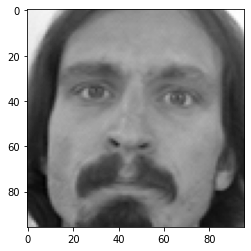

In [6]:
#exemplo de imagem plotada
plt.imshow(faces[0], cmap='gray')


In [7]:
#vendo as colunas do csv e suas contidades de elementos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

In [0]:
#Ao observar o código a cima podemos analisar que algumas imagens, não poussem
#todos os pontos, logo precisamos remover estas imagens
images_corrigidas = []
index_descartados = []
imagens_descartadas = []

for i in range(len(faces)):

    if(df.iloc[i].isnull().values.any() == False):
      images_corrigidas.append(faces[i])
    
    else:
      index_descartados.append(i)
      imagens_descartadas.append(faces[i])


In [9]:
#convertendo as imagens corridias em np array
images_corrigidas = np.array(images_corrigidas)
images_corrigidas = images_corrigidas/255
images_corrigidas.shape

(2140, 96, 96)

In [0]:
#dropando as linhas onde os valores estavam incompletos 
df = df.drop(index_descartados)

In [11]:
#verificando
df.shape

(2140, 30)

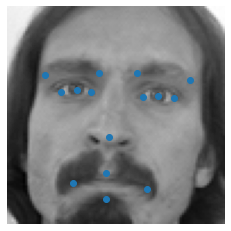

In [12]:

def analisar_pontos_dataframe(faces, df):
  '''Esta função plota as cordernadas dos pontos presentes no data frame, para 
   visualização da imagem com as landmarks
  '''
  #Criando lista com números pares e impáres com o total de colunas 
  lista_even = [num for num in range(0,len(df.columns),2)]
  lista_odd = [num + 1 for num in lista_even]

  #pegando as colunas pares para as coordenadas X dos ponto
  df_column_even = df.iloc[:,lista_even]

  #pegando as colunas impar para as coordenadas Y dos ponto
  df_column_odd = df.iloc[:,lista_odd]

  #selecionado as coordenadas X e Y, da imagem 0 
  X = df_column_even.iloc[0]
  Y = df_column_odd.iloc[0]

  plt.imshow(faces[0]/255, cmap='gray')
  plt.axis('off')
  plt.scatter(X,Y)

analisar_pontos_dataframe(images_corrigidas, df)


In [0]:
#seprando a função 
X_train, X_test, y_train, y_test = train_test_split(images_corrigidas, np.array(df), test_size=0.1)

#normalizando para poder usar sigmoid
y_train = y_train/96
y_test = y_test/96

In [0]:
def Criar_CNN():
    'Esta função cria o modelo utilizado'
    CNN = keras.Sequential()
    CNN.add(keras.layers.InputLayer(input_shape = (96,96,1)))
    CNN.add(keras.layers.ZeroPadding2D((2,2)))
    CNN.add(keras.layers.Conv2D(filters =  96 , kernel_size =  (5,5),
        strides = 1))
    CNN.add(keras.layers.ReLU())

    CNN.add(keras.layers.ZeroPadding2D((2,2)))
    CNN.add(keras.layers.Conv2D(filters =  96 , kernel_size =  (5,5),
        strides = 1))
    CNN.add(keras.layers.ReLU())
    CNN.add(keras.layers.MaxPool2D(pool_size=(2,2), strides = (2,2)))

    CNN.add(keras.layers.ZeroPadding2D((2,2)))
    CNN.add(keras.layers.Conv2D(filters =  48 , kernel_size =  (4,4),
        strides = 1))
    CNN.add(keras.layers.ReLU())
    CNN.add(keras.layers.Conv2D(filters =  48 , kernel_size =  (4,4),
        strides = 1))
    CNN.add(keras.layers.ReLU())
    CNN.add(keras.layers.MaxPool2D(pool_size=(2,2), strides = (2,2)))

    CNN.add(keras.layers.ZeroPadding2D((2,2)))
    CNN.add(keras.layers.Conv2D(filters =  48 , kernel_size =  (3,3),
        strides = 1))
    CNN.add(keras.layers.ReLU())
    CNN.add(keras.layers.Conv2D(filters =  48 , kernel_size =  (3,3),
        strides = 1))
    CNN.add(keras.layers.ReLU())
    CNN.add(keras.layers.MaxPool2D(pool_size=(3,3), strides = (3,3)))
    
      
    CNN.add(keras.layers.Conv2D(filters =  30 , kernel_size =  (3,3),
        strides = 1, activation = 'relu'))
    CNN.add(keras.layers.Conv2D(filters =  30 , kernel_size =  (3,3),
        strides = 1, activation = 'relu'))
    CNN.add(keras.layers.Conv2D(filters =  30 , kernel_size =  (3,3),
        strides = 1, activation = 'sigmoid'))



    #se usa metodos de regressão 
    CNN.compile(loss = 'MSE', optimizer = keras.optimizers.Adam(learning_rate= 0.00001), metrics=['mse']) 
     
    return CNN

CNN = Criar_CNN()

In [15]:
CNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 100, 100, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 96)        2496      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 96, 96, 96)        0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 100, 100, 96)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 96)        230496    
_________________________________________________________________
re_lu_2 (ReLU)               (None, 96, 96, 96)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 96)       

In [16]:
#treinando a rede
CNN.fit(np.expand_dims(X_train, -1),np.reshape(y_train, ( -1 , 1 , 1 , 30 )), epochs = 50)

Epoch 1/50
1926/1926 [==============================] - 18s 9ms/step - loss: 0.0377 - mse: 0.0377
Epoch 2/50
1926/1926 [==============================] - 10s 5ms/step - loss: 0.0327 - mse: 0.0327
Epoch 3/50
1926/1926 [==============================] - 10s 5ms/step - loss: 0.0240 - mse: 0.0240
Epoch 4/50
1926/1926 [==============================] - 10s 5ms/step - loss: 0.0167 - mse: 0.0167
Epoch 5/50
1926/1926 [==============================] - 10s 5ms/step - loss: 0.0106 - mse: 0.0106
Epoch 6/50
1926/1926 [==============================] - 10s 5ms/step - loss: 0.0066 - mse: 0.0066
Epoch 7/50
1926/1926 [==============================] - 10s 5ms/step - loss: 0.0045 - mse: 0.0045
Epoch 8/50
1926/1926 [==============================] - 10s 5ms/step - loss: 0.0035 - mse: 0.0035
Epoch 9/50
1926/1926 [==============================] - 10s 5ms/step - loss: 0.0029 - mse: 0.0029
Epoch 10/50
1926/1926 [==============================] - 10s 5ms/step - loss: 0.0026 - mse: 0.0026
Epoch 11/50
1926/19

In [17]:
CNN.evaluate(np.expand_dims(X_test, -1),np.reshape(y_test, ( -1 , 1 , 1 , 30 )))

214/214 [==============================] - 1s 5ms/step


[0.0010667645794591892, 0.001066764467395842]

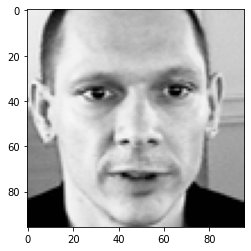

In [18]:
#escolhendo uma imagem para compara landmarks da rede x anotada manualmente
img_teste = X_test[1]
plt.imshow(img_teste, cmap='gray')

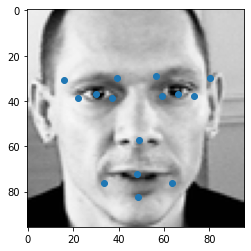

In [19]:
def Plot_landmarks_CNN(img_teste):
  'Esta função plota na imagem os pontos da saida da CNN'
  
  img_test = np.expand_dims(img_teste,-1)
  img_test = np.expand_dims(img_test, 0)
  img_test.shape
  pontos = CNN.predict(img_test)
  pontos = pontos[0,0,0,:]*96
  X = []
  Y = []

  for i in range(0,len(pontos),2):
    X.append(pontos[i])

  for i in range(1,len(pontos),2):
    Y.append(pontos[i])

  plt.imshow(img_test[0,:,:,0], cmap = 'gray')
  plt.scatter(X,Y)

Plot_landmarks_CNN(img_teste)

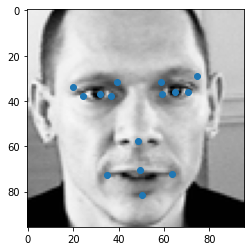

In [20]:
def Plot_landmarks_anotadas(img_teste,y_test):
  'Esta função plota na imagem os pontos da reais anotados por uma pessoa'
  
  X = []
  Y = []
  y_test = y_test*96
  for i in range(0,len(y_test),2):
    X.append(y_test[i])

  for i in range(1,len(y_test),2):
    Y.append(y_test[i])

  plt.imshow(img_teste, cmap = 'gray')
  plt.scatter(X,Y)

Plot_landmarks_anotadas(img_teste,y_test[1])

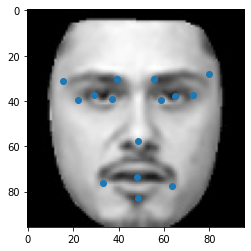

In [22]:
#testando em uma imagem do data set
img_internet = cv2.imread('/content/Neutro23844.jpg')
img_internet = img_internet[:,:,0]
img_internet = cv2.resize(img_internet, (96,96), interpolation = cv2.INTER_CUBIC)

Plot_landmarks_CNN(img_internet/255)